# Tracking in multiple dimensions

In [289]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from filterjax import KalmanFilter, KalmanParams, plot_posterior_covariance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## One dimension

**TO DO**: move dog tracking notebook here

## Two dimensions

In [44]:
class PositionSensor:

    def __init__(self, pos=[0, 0], vel=(0, 0), noise=1.):
        self.pos = pos
        self.vel = vel
        self.noise = noise
    
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]

        return [self.pos[0] + np.random.randn() * self.noise,
                self.pos[1] + np.random.randn() * self.noise]

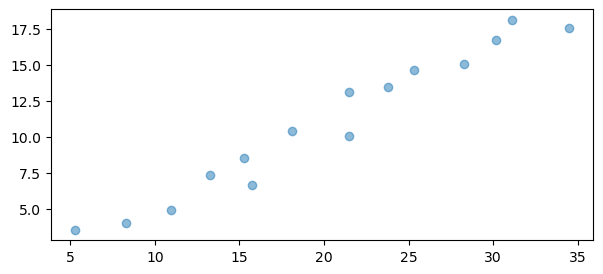

In [273]:
ps = PositionSensor([4, 3], (2, 1), 1)
emissions = jnp.array([ps.read() for _ in range(15)])

plt.figure(figsize=(7, 3))
plt.scatter(
    emissions[:, 0], emissions[:, 1],
    alpha=0.5
);

## Design the Kalman Filter

### Step 1. Choose the state variables

Since we are tracking in two dimensions and have a sensor that returns a measurement in each of the two coordindates ($x-y$ plane), we have two _observed_ variables $x$ and $y$. However, we now have two _unobserved_ variables where the unobserved variables are the velocity of the $x$ and $y$ states. 

In [259]:
m = jnp.array([0, 0, 0, 0], dtype=jnp.float32)
m

Array([0., 0., 0., 0.], dtype=float32)

### Step 2. Design the state transition matrix

The state transition matrix is the matrix that we multiply with the previous state of the system to get the next state.

In [34]:
# assume measurement every seoncd
dt = 1.
F = jnp.array([
    [1., dt, 0, 0],
    [0, 1., 0, 0],
    [0, 0, 1., dt],
    [0, 0, 0, 1.]
])
F

Array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]], dtype=float32)

### Step 3: Design the motion function

There are no control inputs, so we can set this term to zero. Default is zero.

### Step 4: Design the measurement function

The measurement function $\mathbf{H}$ defines how we go from the state variables to the measurements. This function is needed because with the Kalman Filter, we go from measurements to state variables. However, the update step needs to compute the residual between the current measurement and the measuremen represented by the prediction step. Therefore, $\mathbf{H}$ is multiplied by the state $x$ to produce a measurement $z$

$$z = \mathbf{H}x$$

Since state and measurement are both positions, $(x, y)$, we don't need to do any converting here.

In [33]:
H = jnp.array([
    [1., 0, 0, 0],
    [0, 0, 1., 0]
])
H

Array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

### Step 5: Design the measurement noise matrix

The measurement noise matrix models the noise in the sensor's measurements.

In [291]:
R = jnp.array([
    [5, 0],
    [0, 5]
])
R

Array([[5, 0],
       [0, 5]], dtype=int32)

### Step 6: Design the process noise matrix

The process noise matrix models the process (). This is the noise that is added to the state variables at each time step.

In [12]:
Q = jnp.eye(4) * 0.1
Q

Array([[0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. ],
       [0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0.1]], dtype=float32)

### Step 7: Design initial conditions

In [303]:
P = jnp.eye(4) * 100
P

Array([[100.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.]], dtype=float32)

## Kalman filter implementation

In [304]:
params = KalmanParams(m, F, H, R, Q, P)

kf = KalmanFilter(4., 2.)
params = kf.initialize(params)
posterior = kf.filter(params, emissions)

### Plotting filter results

#### Plot mean position

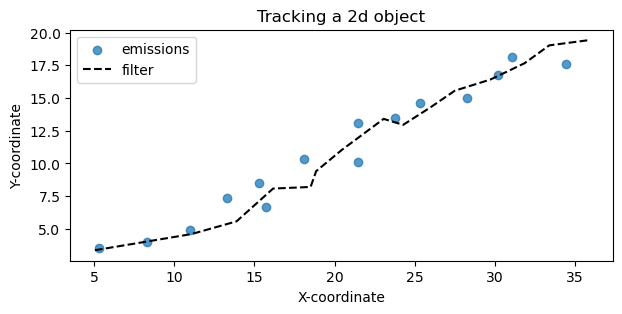

In [305]:
# posterior.mean --> [x, vx, y, vy]
plt.figure(figsize=(7, 3))
plt.scatter(
    emissions[:, 0], emissions[:, 1],
    alpha=0.75, label="emissions"
)
plt.plot(
    posterior.mean[:, 0], posterior.mean[:, 2],
    linestyle="--", color="black",
    label="filter"
)
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("Tracking a 2d object")
plt.legend();

#### Plot position covariance

In [315]:
xy_cov = []
for cov in posterior.covariance:
    xy_cov.append(
        jnp.array(
            [[cov[0, 0], cov[0, 2]], 
            [cov[2, 0], cov[2, 2]]]
            )
        )
    
xy_cov = jnp.array(xy_cov)

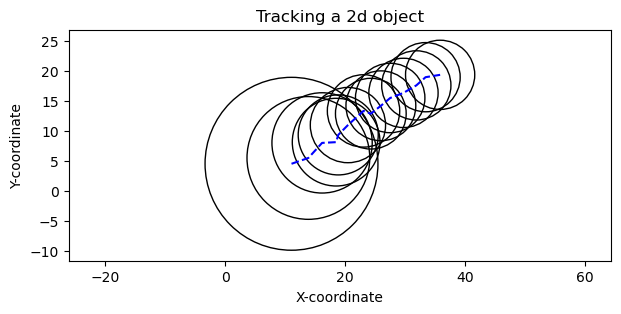

In [316]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    posterior.mean[1:, 0], posterior.mean[1:, 2],
    linestyle="--", color="blue",
    label="filter"
)
ax = plot_posterior(
    posterior.mean[1:, [0, 2]],
    xy_cov[1:],
    ax=ax,
    legend_kwargs={"legend": "covariance"}
)
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_title("Tracking a 2d object");